<a href="https://colab.research.google.com/github/SiluniKeerthiratne/DSGP/blob/nisal/%20v3%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import os
import cv2
from tqdm import tqdm
from tqdm import tqdm_notebook

In [3]:
# Assuming the 'fruit-dta' directory is in the root of your Google Drive
root_dir = '/content/drive/MyDrive/Colab Notebooks/fruit-dta'

In [4]:
# List of fruit classes: 'mango', 'banana'
fruit_classes = ['banana','mango','tomato'] # add more fruits and veg classes
ripeness_classes = ['0 unripe', '1 partially ripe', '2 ripe']

X = []
y = []

for fruit_class in fruit_classes:
    for ripeness_class_label, ripeness_class in enumerate(ripeness_classes):
        class_path = os.path.join(root_dir, fruit_class, ripeness_class)
        for img_name in tqdm(os.listdir(class_path)):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (244, 244))
            X.append(img)
            y.append(ripeness_class_label)

100%|██████████| 305/305 [00:10<00:00, 27.92it/s]


In [5]:
# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
import numpy as np

# Convert to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [7]:
# Print shapes
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (1372, 244, 244, 3)
X_test Shape:  (676, 244, 244, 3)
y_train Shape:  (1372,)
y_test Shape:  (676,)


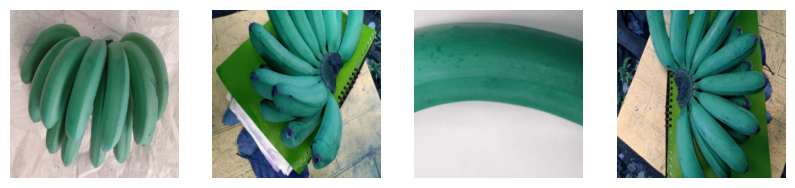

In [8]:
# Visualization (optional)
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

In [9]:
# Model Building (continuation)
from keras.applications import InceptionV3
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras import regularizers

img_rows, img_cols = 244, 244

In [10]:
# Load InceptionV3 model with pre-trained weights
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))

87910968/87910968 [==============================] - 1s 0us/step


In [11]:
# Freeze the layers
for layer in inception.layers:
    layer.trainable = False

In [12]:
# Custom head
def custom_head(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(top_model)
    top_model = Dropout(0.5)(top_model)  # Add dropout for regularization
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model

In [13]:
# Add custom head on top of InceptionV3
num_classes = len(ripeness_classes)
FC_Head = custom_head(inception, num_classes)
model = Model(inputs=inception.input, outputs=FC_Head)


In [14]:
# Model summary
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 121, 121, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 121, 121, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [15]:
# Model compilation
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Model Training
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), verbose=1, initial_epoch=0)

Epoch 1/30
43/43 [==============================] - 367s 8s/step - loss: 12.4739 - accuracy: 0.3950 - val_loss: 2.2835 - val_accuracy: 0.4941
Epoch 2/30
43/43 [==============================] - 353s 8s/step - loss: 2.1810 - accuracy: 0.4891 - val_loss: 2.0676 - val_accuracy: 0.5754
Epoch 3/30
43/43 [==============================] - 355s 8s/step - loss: 2.0653 - accuracy: 0.4789 - val_loss: 2.0029 - val_accuracy: 0.5991
Epoch 4/30
43/43 [==============================] - 312s 7s/step - loss: 1.9486 - accuracy: 0.5066 - val_loss: 1.8393 - val_accuracy: 0.6716
Epoch 5/30
43/43 [==============================] - 314s 7s/step - loss: 1.8840 - accuracy: 0.5007 - val_loss: 1.6906 - val_accuracy: 0.6908
Epoch 6/30
43/43 [==============================] - 350s 8s/step - loss: 1.8139 - accuracy: 0.5241 - val_loss: 1.6032 - val_accuracy: 0.6760
Epoch 7/30
43/43 [==============================] - 351s 8s/step - loss: 1.7798 - accuracy: 0.5430 - val_loss: 1.7046 - val_accuracy: 0.6450
Epoch 8/30
4

In [25]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
# Get true labels
true_labels = y_test

# Get predictions
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=-1)

# Calculate accuracy
accuracy = np.mean(true_labels == predicted_labels)*100
print("Accuracy:", accuracy,"%")

# Calculate precision, recall, f1-score, and support
ripeness_classes_names = [str(i) for i in range(len(ripeness_classes))]  # Assuming class indices as numbers
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=ripeness_classes_names))

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

22/22 [==============================] - 103s 5s/step
Accuracy: 74.70414201183432 %
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.99      0.87       276
           1       0.86      0.05      0.09       125
           2       0.72      0.83      0.77       275

    accuracy                           0.75       676
   macro avg       0.78      0.62      0.57       676
weighted avg       0.77      0.75      0.68       676

Confusion Matrix:
[[272   0   4]
 [ 33   6  86]
 [ 47   1 227]]


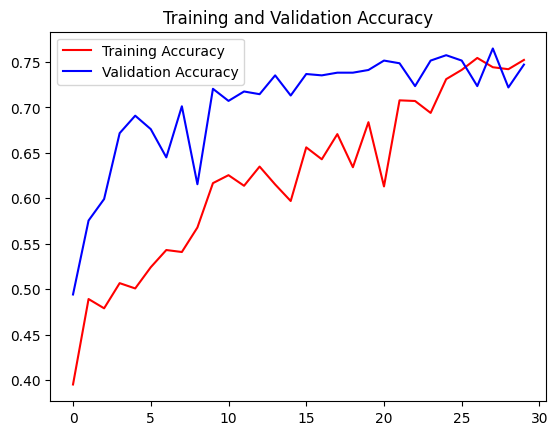

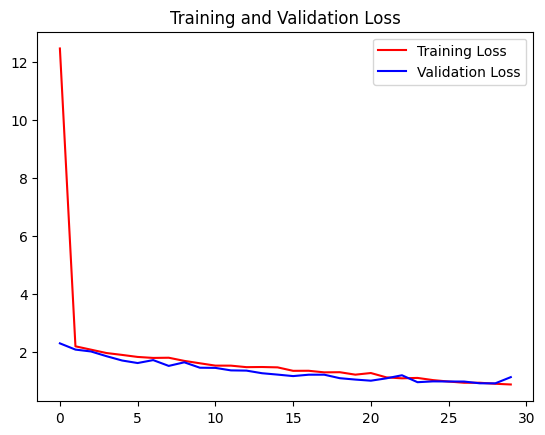

In [27]:
# Visualization of Training History
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [28]:
# Save the entire model to a file
model.save('/content/drive/MyDrive/Colab Notebooks/fruit-dta/trained_model.h5')
